This part of the Tutorial will show how the Data was prepared for the retrieval of the periods from the TESS full frame image. This is the step of pre detrending.

The first step of this is reading in the Data from the FITs file. This can be substituted as necessary to the form the data is stored in your case. We load the Dataset of 2MASS J04195212+4233304 that was prepared by Domenico Nardiello

In [2]:
#We import the fits module from astropy.io to read the fits file.
from astropy.io import fits
from pathlib import Path


#### This part can be replaced with however you read in your data
Data_Path = Path("Example Data/MainExample.fits")
FITS = fits.open(Data_Path)
Dataset = FITS[1].data #Access the Data of the HDU BINTableHDU

Dataset.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BTJD, d'
    name = 'TIMECORR'; format = 'E'; unit = 'd'
    name = 'PSF_FLUX_RAW'; format = 'D'; unit = 'e-/s'
    name = 'PSF_FLUX_COR'; format = 'D'; unit = 'e-/s'
    name = 'AP1_FLUX_RAW'; format = 'D'; unit = 'e-/s'
    name = 'AP1_FLUX_COR'; format = 'D'; unit = 'e-/s'
    name = 'AP2_FLUX_RAW'; format = 'D'; unit = 'e-/s'
    name = 'AP2_FLUX_COR'; format = 'D'; unit = 'e-/s'
    name = 'AP3_FLUX_RAW'; format = 'D'; unit = 'e-/s'
    name = 'AP3_FLUX_COR'; format = 'D'; unit = 'e-/s'
    name = 'AP4_FLUX_RAW'; format = 'D'; unit = 'e-/s'
    name = 'AP4_FLUX_COR'; format = 'D'; unit = 'e-/s'
    name = 'SKY_LOCAL'; format = 'D'; unit = 'e-/s'
    name = 'X_POSITION'; format = 'D'; unit = 'pixel'
    name = 'Y_POSITION'; format = 'D'; unit = 'pixel'
    name = 'DQUALITY'; format = 'I'
)

In our case we have our Data in 5 different apertures PSF, and AP1 to AP4 and the Background. Additionaly we have the centroid position in X and Y pixel units and the Dataquality flag from the TESS spacecraft.

We plot all the 5 appertures in their RAW form.

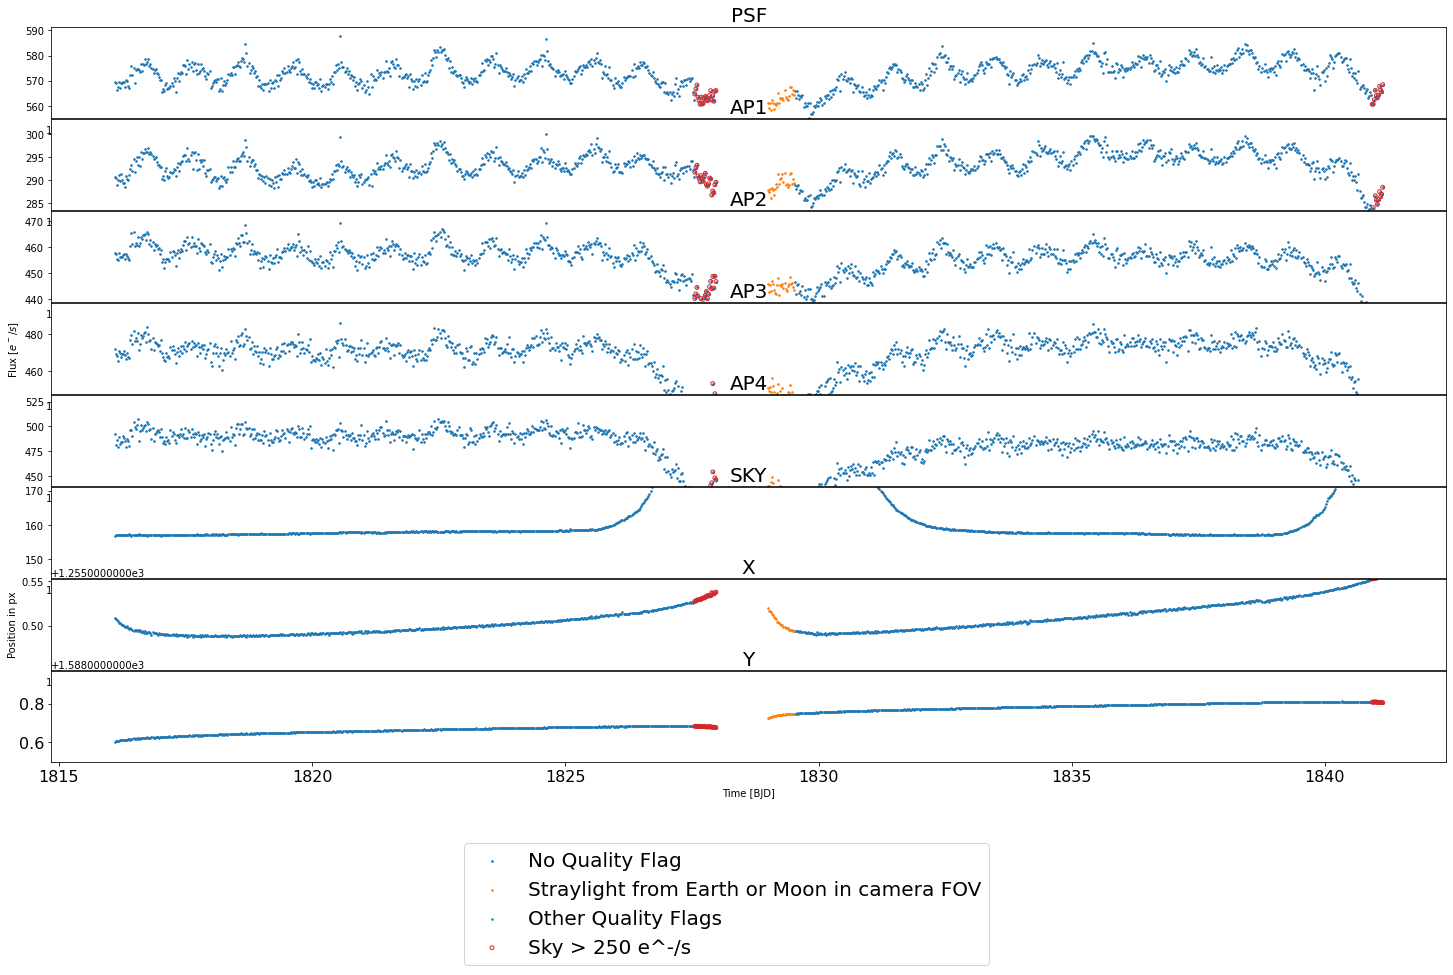

In [3]:
import matplotlib.pyplot as plt
from astropy.stats import sigma_clip

#The Column Names of the Data
Curve_Names = ["TIME","PSF_FLUX_COR","AP1_FLUX_COR","AP2_FLUX_COR","AP3_FLUX_COR","AP4_FLUX_COR","SKY_LOCAL","X_POSITION","Y_POSITION"]
Curve_Labels = ["PSF","AP1","AP2","AP3","AP4","SKY","X","Y"] #Label Names of the individual Plots

#Prepare the Masking for different Quality Flags
Sky_250 = Dataset["SKY_LOCAL"]>250 #Mask all points where the Background exceed 250 Flux Counts
Tag_0 = Dataset["DQUALITY"] == 0 #Mask TESS Flag 0 which is best quality 
Tag_2048 = Dataset["DQUALITY"] == 2048 #TESS Flag 2048 Straylight
OtherTags = ~((Dataset["DQUALITY"] == 0) | (Dataset["DQUALITY"] == 2048)) #Marks all the Other Flags

#List all the Important Tags in a List
Tags_list = [Tag_0,Tag_2048,OtherTags] 
Tags_name = ["No Quality Flag","Straylight from Earth or Moon in camera FOV","Other Quality Flags","Other Quality Flags"]
Tags_colors = ["C0","C1","C2"]

n = len(Curve_Names) - 1

#Prepare Subplots for the Plotting of all Important Time Series
fig = plt.figure(figsize=(25,15))
gs_test = fig.add_gridspec(n,1)

ax = []
for i in range(n):
    tax = fig.add_subplot(gs_test[i])
    ax.append(tax)
plt.subplots_adjust(hspace=0.01)


##Plot each of the Data Columns except for TIME against the TIME column.
for i,key in enumerate(Curve_Names[1:]):
    Clipped_Array,lowerbound,upperbound = sigma_clip(Dataset[key],return_bounds=True) #3 Sigma Clip to show the variation we are searching for as otherwise the outliers do  obscure the view

    #Plot the Data for each Flag in a different Color
    for j in range(3):
        Mask = Tags_list[j]
        scatter = ax[i].scatter(Dataset["TIME"][Mask],Dataset[key][Mask],marker=".",s=10,color = Tags_colors[j],label=Tags_name[j])
    
    #Plot the Data above 250 Flux in the background
    ax[i].scatter(Dataset["TIME"][Sky_250],Dataset[key][Sky_250],marker="o",edgecolors="C3",s=15,color="None",label="Sky > 250 e^-/s")

    # Use the sigma clipped bounds to determine the y limit
    total_y = upperbound-lowerbound 
    ax[i].set_ylim(lowerbound - 0.1*total_y,upperbound + 0.1*total_y)
    ax[i].set_title(Curve_Labels[i],fontsize=20)

ax[3].set_ylabel("Flux [$e^-/s$]")

for a in ax[-2:-1]:
    a.set_ylabel("Position in px")

ax[-1].set_xlabel("Time [BJD]")
fig.subplots_adjust(bottom=0.2) 
h,l = ax[-1].get_legend_handles_labels()
fig.legend(h,l,loc="lower center",fontsize=20)
ax[-1].tick_params(labelsize=16)

fig.savefig("Plots/Raw.png")

Additionally it is imperative to Observe the Apertures that the Data was taken in, to judge the quality and how much we can trust the lightcurves. To do this we overplot the Apertures over the Cut of the TESS images. To do this we can use Lightkurve and the plotting function imshow_norm from 

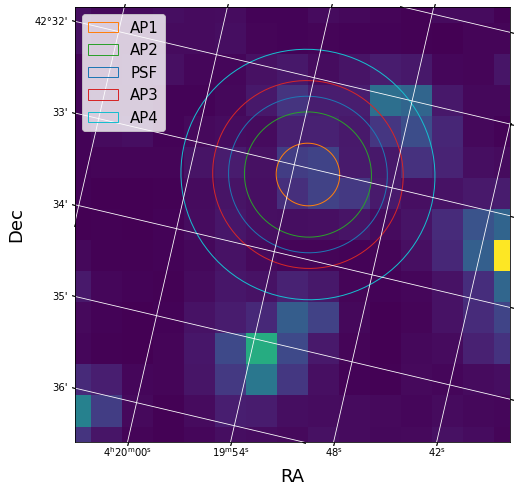

In [4]:
import lightkurve
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization import (imshow_norm,ZScaleInterval)
import numpy as np
import astropy.units as u

#List of Aperture Sizes and calculate
Apertures = np.array([1,2,2.5,3,4]) #in TESS pixels
AP_arcsec = Apertures*21*u.arcsec #21 arcsec/pixel
colors = ["C1","C2","C0","C3","C9"]
names = ["AP1","AP2","PSF","AP3","AP4"]

#index of the multiple images taken in a TESS Sector
idx= 0

#Downloading the Cut of the Identifier
result = lightkurve.search_tesscut("2MASS J04195212+4233304")
tess = result.download(cutout_size=15)
wcs_tess = tess.wcs #This is the World Coordinate System (wcs) of the TESS which is used to transform to the coordinates in the TESS image.

#Centroid Positions at index
x = Dataset["X_Position"][idx]
y = Dataset["y_Position"][idx]

cord_aperture = wcs_tess.pixel_to_world(x-tess.column,y-tess.row) # Calculate the coordianattes in RA and Dec of the centroid

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection=wcs_tess) #Add subplot and add the projection

ax.imshow(tess.flux[idx].value) # Plot the image of the TESS Cut

#plot all 5 Apertures
for i in range(5):
    
    r = SphericalCircle((cord_aperture.ra , cord_aperture.dec),AP_arcsec[i],edgecolor=colors[i], facecolor='none',transform=ax.get_transform('icrs'),label=names[i])
    ax.add_patch(r)

ax.coords.grid(True, color='white', ls='solid')
ax.set_xlabel('RA',fontsize=18)
ax.set_ylabel('Dec',fontsize=18)
ax.set_ylim(0,14)
ax.set_xlim(0,14)
ax.legend(fontsize=15)

Additionally we want to correct for discontinuities or steps in the photometric lightcurve. We do this for all 5 apertures but we show this exemplary only for one aperture of another example as there are no discontinuities in the main example.

[Text(0.5, 0, '[BJD]'), Text(0, 0.5, 'Flux [e^-/s]')]

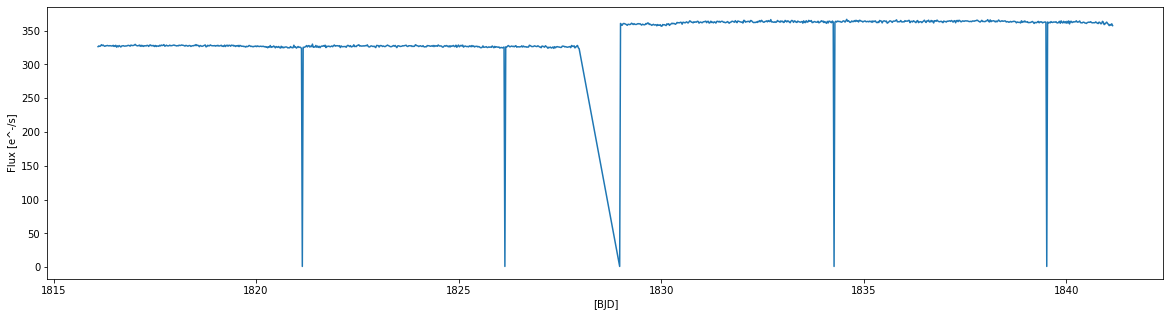

In [5]:
Data_Path = Path("Example Data/ExampleDiscontinuity.fits")
FITS_DISC = fits.open(Data_Path)
Discontinuity = FITS_DISC[1].data #Access the Data of the HDU BINTableHDU

plt.figure(figsize=(20,5))
plt.plot(Discontinuity["TIME"],Discontinuity["AP1_FLUX_COR"])
plt.gca().set(xlabel="[BJD]",ylabel="Flux [e^-/s]")

To make our live easier and so we do not have to count at which index the discontinuity is, we employ a changepoint algorithm via ruptures, to find the discontinuities.

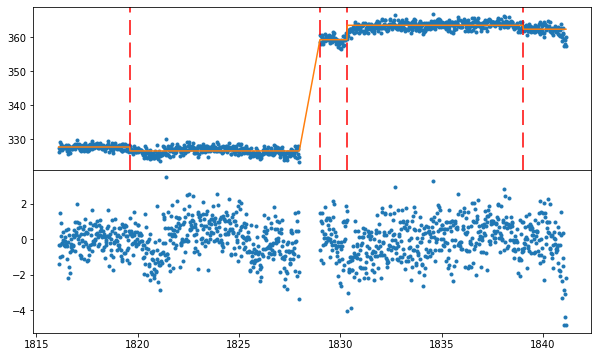

In [6]:
import ruptures as rpt
import TESS_Var

#Mask out all non flag 0
Mask = Discontinuity["DQUALITY"] == 0

Flux_disc = Discontinuity["AP1_FLUX_COR"][Mask]
Time_disc = Discontinuity["TIME"][Mask]

#Use ruptures to find the discontinuities
algo = rpt.Pelt(model="l2",min_size=30).fit(Flux_disc)
res = algo.predict(pen=100)
result = np.array(res[:-1]) #Last point in list is the length of array
result = result - 1 #the indexing needs to be shifted by one otherwise we get outliers

#We find the medians of each segment with the median_multi_segment described in TESS_Var.py
Medians = TESS_Var.median_multi_segment(Flux_disc,result)

#Calculate the correction by which we set the median of each segment to 0.
Corrected = Flux_disc - Medians


fig,ax = plt.subplots(2,1,figsize=(10,6),sharex=True)
ax[0].plot(Time_disc,Flux_disc,".")
for l in result:
    ax[0].axvline(Time_disc[l],dashes=[10,5],color="r")

ax[0].plot(Time_disc, Medians)
ax[1].plot(Time_disc,Corrected,".")

fig.subplots_adjust(hspace=0.0)

Back to our original Data, we select the best Aperture according to the following points:
* The median flux in the raw fluxes, where a higher flux is often better as that means less contribution from the background flux.

* Aperture size and how many other sources are within in the aperture.

* If the apertures flux shows trends that are correlated to the background flux.

* Trends and systematics that are not of periodic origin or can be attributed to non-physical origins.

According to this we select here the PSF Aperture which is the Point Spread Function aperture which also minimizes the contamination from other sources. Additionaly for further steps we remove the Data that has other Quality Flags than 0.

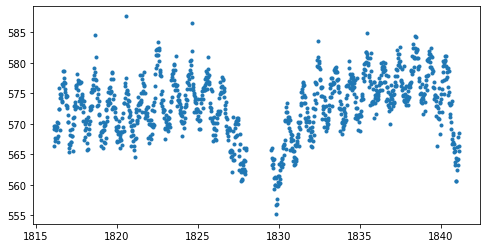

In [7]:
Flux = Dataset["PSF_FLUX_COR"][Tag_0]
Time = Dataset["Time"][Tag_0]

plt.figure(figsize=(8,4))
plt.plot(Time,Flux,".")

Now lastly we use a Gaussian Process to remove some long term trends. We use the Gaussian process with the Radial basis function kernel as implemented in Wotan.

c:\ProgramData\Anaconda\envs\Bachelor\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 50.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\ProgramData\Anaconda\envs\Bachelor\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 50.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


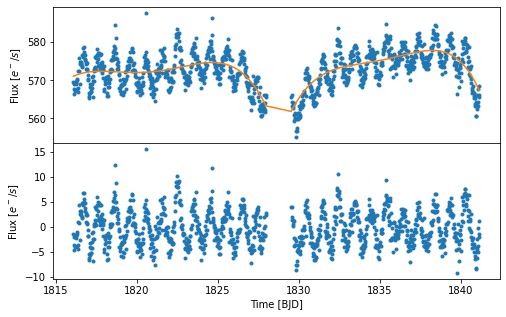

In [8]:
from wotan import flatten

size = 100 #Take care to set the size very large so it doesnt take into account smaller variations which are the periods we want to retrieve.
flattened,trend_lc = flatten(Time,Flux,method="gp",kernel="squared_exp",kernel_size=size,return_trend=True) #The Squared Exponent is the RBF kernel.


F_GP = Flux - trend_lc #Subtract the Trend Curve from the Lightcurve to flatten out the long term trends
fig,ax = plt.subplots(2,1,figsize=(8,5),sharex=True)


ax[0].plot(Time,Flux,".")
ax[0].plot(Time,trend_lc)
ax[1].plot(Time,F_GP,".")
ax[1].set(xlabel="Time [BJD]",ylabel="Flux [$e^-/s$]")
ax[0].set(ylabel="Flux [$e^-/s$]")

fig.subplots_adjust(hspace=0.0)

And lastly we want to select and mask out the outliers.

In [9]:
from plotly import graph_objects as go

plot = go.Scatter(x=Time.astype("float"),y=F_GP.astype("float") ,mode="markers")
f = go.FigureWidget(plot)

scatter = f.data[0]
FeatureMask = np.ones_like(Time,dtype=bool)

def save_select(trace, points, selector):

    FeatureMask[points.point_inds] = False
    
    
scatter.on_selection(save_select)

f

FigureWidget({
    'data': [{'mode': 'markers',
              'type': 'scatter',
              'uid': 'c1ddb69…

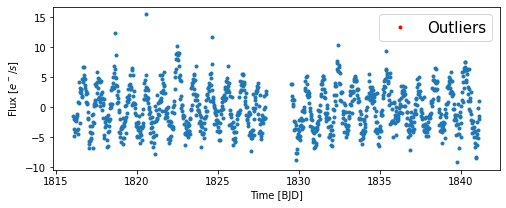

In [10]:
plt.figure(figsize=(8,3))
plt.plot(Time,F_GP,".")
plt.plot(Time[~FeatureMask],F_GP[~FeatureMask],".r",label="Outliers")
plt.gca().set(xlabel="Time [BJD]",ylabel="Flux [$e^-/s$]")
plt.legend(fontsize=15)

This is all that is part of the Pre-Detrending now we will save the important data and go to the next notebook which describes the retrieval of the Periods.

In [11]:
np.savez("Example Data/Pre_detrended.npz",Time = Time,Flux = F_GP,FeatureMask = FeatureMask,)